# Publications by Year

In [111]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# setup mongo conenction to DB in clustercien
import pymongo
from pymongo import MongoClient
db_client = MongoClient('172.19.31.5', 27017)
db = db_client['inspirehep']
articles = db['articles']        # use the "articles" collection of the database

In [115]:
cursor = articles.find(
    {},   # query search
    {'created': 1}    # fields contained in result
)

In [116]:
documents = list(cursor)

In [117]:
df = pd.DataFrame(documents)

In [118]:
df.shape

(14998, 2)

In [119]:
df.created = pd.to_datetime(df.created)

In [120]:
grouped_by_year_df = df.groupby(df.created.dt.year)['created'].count()

In [121]:
plt.rcParams.update({'font.size': 18})

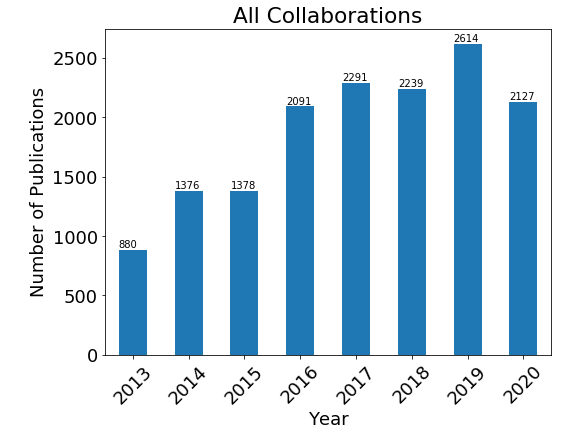

In [122]:
fig, ax = plt.subplots(nrows=1, ncols=1)

grouped_by_year_df.plot.bar(ax = ax, rot = 45, figsize = (8,6))

ax.set_xlabel('Year')
ax.set_ylabel('Number of Publications')
ax.set_title('All Collaborations')

ax.set_xlim(1.5,9.5)

for p in ax.patches:
    ax.annotate('{}'.format(p.get_height()), (p.get_x(), p.get_height()+20), size=10)

# CMS and ATLAS 

Get a pointer to all the documents in the articles collection of the database only with the interesting fields.

In [226]:
cursor = articles.find(
    {},   # query search
    {'created': 1,
     'metadata.collaborations': 1
    }    # fields contained in result
)

and turn them into a pandas dataframe

In [227]:
df = pd.DataFrame(list(cursor))
df.sample(10)

,_id,created,metadata
6789,1592277,2017-04-19T00:00:00+00:00,{'collaborations': [{'value': 'ALICE'}]}
5032,1633431,2017-10-31T00:00:00+00:00,{'collaborations': [{'value': 'CMS'}]}
3915,1716638,2019-01-25T00:00:00+00:00,{}
5284,1699708,2018-10-23T00:00:00+00:00,{}
4891,1760950,2019-10-25T00:00:00+00:00,{}
9951,1414069,2016-01-07T00:00:00+00:00,{'collaborations': [{'value': 'ALICE'}]}
413,1798846,2020-06-02T00:00:00+00:00,{'collaborations': [{'value': 'ATLAS'}]}
7774,1596563,2017-04-26T00:00:00+00:00,{'collaborations': [{'value': 'CMS'}]}
4451,1752917,2019-09-09T00:00:00+00:00,{}
9493,1436496,2016-03-31T00:00:00+00:00,{'collaborations': [{'value': 'ATLAS'}]}


Turn the "created" column into datetime type

In [184]:
df.created = pd.to_datetime(df.created)

To unpack the values in the metadata dictionary lets create a new set of columns in the dataframe that indicates if the article is in a certain collaboration:

In [186]:
def filter(dic):
    new_columns = {'ATLAS': False, 
                   'CMS': False, 
                   'ALICE': False, 
                   'LHCb': False, 
                   'others': False}
    
    if 'collaborations' in dic.keys():
        
        for colab in dic['collaborations']:
            if ('ATLAS' in colab['value']):
                new_columns['ATLAS'] = True
            elif ('CMS' in colab['value']):
                new_columns['CMS'] = True
            elif ('ALICE' in colab['value']):
                new_columns['ALICE'] = True
            elif ('LHCb' in colab['value']):
                new_columns['LHCb'] = True
            else:
                new_columns['others'] = True
    else:
        new_columns['others'] = True
    
    return new_columns

df = pd.concat([df,
           pd.DataFrame(list(df.metadata.map(filter).values))],
         axis=1)

this is how it looks like after the operation is performed

In [187]:
df.sample(10)

,_id,created,metadata,ALICE,ATLAS,CMS,LHCb,others
5110,1667386,2018-04-13 00:00:00+00:00,{},False,False,False,False,True
7011,1732496,2019-05-01 00:00:00+00:00,{},False,False,False,False,True
3890,1674532,2018-05-24 00:00:00+00:00,{'collaborations': [{'value': 'ATLAS'}]},False,True,False,False,False
6068,1643037,2017-12-14 00:00:00+00:00,{},False,False,False,False,True
7720,1509368,2017-01-18 00:00:00+00:00,{},False,False,False,False,True
3886,1674874,2018-05-26 00:00:00+00:00,{'collaborations': [{'value': 'ATLAS'}]},False,True,False,False,False
3574,1823389,2020-10-19 00:00:00+00:00,{},False,False,False,False,True
13500,1592067,2017-04-19 00:00:00+00:00,{},False,False,False,False,True
6917,1519831,2017-03-29 00:00:00+00:00,{'collaborations': [{'value': 'ALICE'}]},True,False,False,False,False
7033,1735795,2019-05-22 00:00:00+00:00,{},False,False,False,False,True


Now group by collaboration and year and then count the number of published articles

In [189]:
ATLAS_counts = df[df.ATLAS == True].groupby(df.created.dt.year)['created'].count().values

CMS_counts = df[df.CMS == True].groupby(df.created.dt.year)['created'].count().values

LHCb_counts = df[df.LHCb == True].groupby(df.created.dt.year)['created'].count().values

ALICE_counts = df[df.ALICE == True].groupby(df.created.dt.year)['created'].count().values

others_counts = df[df.others == True].groupby(df.created.dt.year)['created'].count().values

labels = df[df.ALICE == True].groupby(df.created.dt.year)['created'].count().keys().values

Calculate the total number of articles each year

In [200]:
totals = ATLAS_counts+CMS_counts+LHCb_counts+ALICE_counts+others_counts[-8:]

and plot...

### All articles

This includes articles that cite thos in the collaboration, i.e., the "universe" of the database

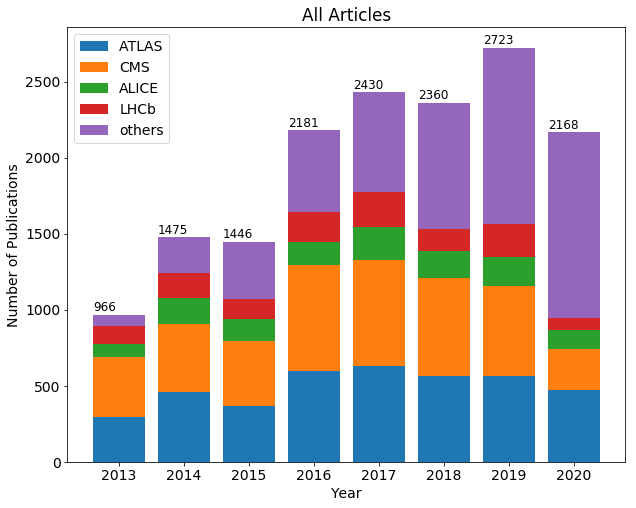

In [220]:
fig, ax = plt.subplots(figsize=(10,8))

plt.rcParams.update({'font.size': 14})

ax.bar(labels, ATLAS_counts, label='ATLAS')
ax.bar(labels, CMS_counts, bottom=ATLAS_counts,label='CMS')
ax.bar(labels, ALICE_counts, bottom=ATLAS_counts+CMS_counts,label='ALICE')
ax.bar(labels, LHCb_counts, bottom=ATLAS_counts+ALICE_counts+CMS_counts,label='LHCb')
bars = ax.bar(labels, others_counts[-len(labels):], bottom=ATLAS_counts+ALICE_counts+CMS_counts+LHCb_counts,label='others')

ax.set_xlabel('Year')
ax.set_ylabel('Number of Publications')
ax.set_title('All Articles')

for p in bars.patches:
    idx = bars.patches.index(p)
    ax.annotate('{}'.format(totals[idx]), (p.get_x(), totals[idx]+25), size=12)

ax.legend()

##  Collaborations only

Only articles belonging to the ATLAS + CMS + LHCb + ALICE set

In [222]:
collab_totals = ATLAS_counts+CMS_counts+LHCb_counts+ALICE_counts

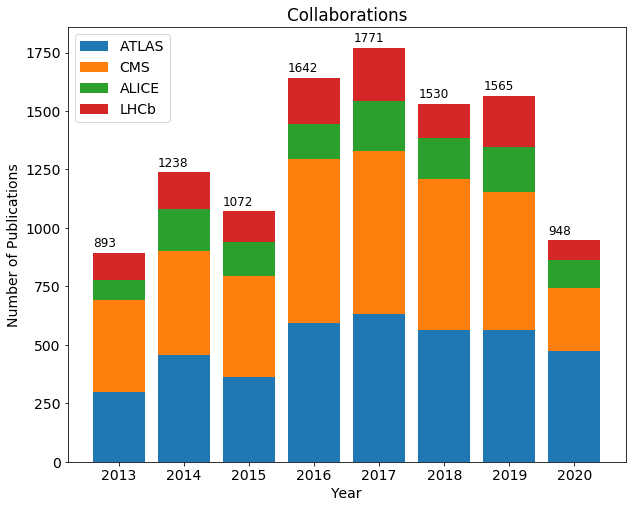

In [224]:
fig, ax = plt.subplots(figsize=(10,8))

plt.rcParams.update({'font.size': 14})

ax.bar(labels, ATLAS_counts, label='ATLAS')
ax.bar(labels, CMS_counts, bottom=ATLAS_counts,label='CMS')
ax.bar(labels, ALICE_counts, bottom=ATLAS_counts+CMS_counts,label='ALICE')
ax.bar(labels, LHCb_counts, bottom=ATLAS_counts+ALICE_counts+CMS_counts,label='LHCb')

ax.set_xlabel('Year')
ax.set_ylabel('Number of Publications')
ax.set_title('Collaborations')

for p in bars.patches:
    idx = bars.patches.index(p)
    ax.annotate('{}'.format(collab_totals[idx]), (p.get_x(), collab_totals[idx]+25), size=12)

ax.legend()